In [1]:
username = "Alex"
pathtorepo = "C:\\Users\\" *username *  "\\Desktop\\"
using Pkg
Pkg.activate(pathtorepo * "dynamical-systems\\env\\integrate\\")

using StaticArrays, DifferentialEquations, DynamicalSystems, JLD2 
using CairoMakie
include("C:\\Users\\Alex\\Desktop\\dynamical-systems\\system.jl");

  Activating project at `C:\Users\Alex\Desktop\dynamical-systems\env\integrate`


In [2]:
function output(idx, parameter, u0)
    println("index: $idx; αE: $parameter");flush(stdout)
    println("u0: $u0");flush(stdout)
end
function output(Λ, u0)
    println("Λ: $Λ");flush(stdout)
    println("last point: $u0");flush(stdout)
end
function separate()
    println("----------------");flush(stdout)
    println("  ");flush(stdout)
end

separate (generic function with 1 method)

In [3]:
u0_start = SA[0.9445509341100914, 0.74116702856987, 0.7361196042973006, 0.0646914552140727, 0.15145764079879162, 0.0009327645775731449];

In [4]:
tstep = 0.001;
time_transient = 3000; # transient time
time_lse = 1000; # time calculating LSE
integ_set = (alg = Vern9(), adaptive = true, abstol = 1e-15, reltol = 1e-15); # integrator setting
param = TM6_glial_ECM_get_params(); # parameters of model
dict, indexparams = TM6_glial_ECM_help(param);
println(indexparams);


    τ - 1, τD - 2, τF - 3, τy - 4, α - 5, αE - 6, αecm - 7, αp - 8,
    J - 9, U0 - 10, I0 - 11, ΔU0 - 12, β - 13, βecm  -14, βp - 15,
    γp - 16, ecm0 - 17, ecm1 - 18, kecm - 19, θecm - 20, p0 - 21, p1 - 22, θp - 23, kp - 24, ythr - 25, xthr - 26


In [17]:
len = 250;
αE_range = range(0.067, 5.0, length = len);

In [18]:
Λs =  zeros(length(αE_range), 6);
u0s = zeros(length(αE_range), 6);

In [19]:
namefirst = "diagram ";
namelast = " alphaE $(len) autojac 1e-15 adapt"
format = ".jld2";

namefile_LSE = namefirst * "LSE" * namelast * format;
namefile_u0s = namefirst * "u0" * namelast * format;

In [20]:
function lyapunovspectrum_adapt(ds, time_lse; coeff = 10)
    coeff_adapt_time = 1;
    flag = true;
    Λs = lyapunovspectrum(ds, time_lse);
    while flag == true
        checkzero = find_zero(Λs);
        if checkzero == -1
            coeff_adapt_time*=2;
            Λs = lyapunovspectrum(ds, time_lse * coeff_adapt_time * coeff);
        else
            flag = false;
        end
    end
    return Λs, coeff_adapt_time;
end

function find_zero(Λs; tol = 1e-2)
    vec_bool = Vector{Bool}(undef, 6);
    for (index, lp) in enumerate(Λs)
        checknull=  isapprox(lp, 0.0; atol = tol);
        vec_bool[index] = checknull;
    end
    vec_of_true = findall(x->x==true, vec_bool);
    if length(vec_of_true) >=1
        return 0;
    else
        return -1;
    end;
end

find_zero (generic function with 1 method)

In [21]:
for (index, αE) in enumerate(αE_range)

    if index == 1
        global u0 = u0_start
    end

    #output(index, αE, u0)

    param[6] = αE
    ds = CoupledODEs(TM6_glial_ECM,  u0, param, diffeq = integ_set)

    tr, _ = trajectory(ds, time_transient)
    u0 = tr[end]; ds = CoupledODEs(TM6_glial_ECM,  u0, param, diffeq = integ_set)
    #println("calc LSE");flush(stdout)
    Λ, _ = lyapunovspectrum_adapt(ds, time_lse)
    #lyapunovspectrum(ds, time_lse)
    Λs[index, :] = Λ
    u0s[index, :] = u0
    
    jldsave(namefile_LSE; Λs);
    jldsave(namefile_u0s; u0s);
    
    #output(Λs[index, :], u0s[index, :])
    #separate()
    
end

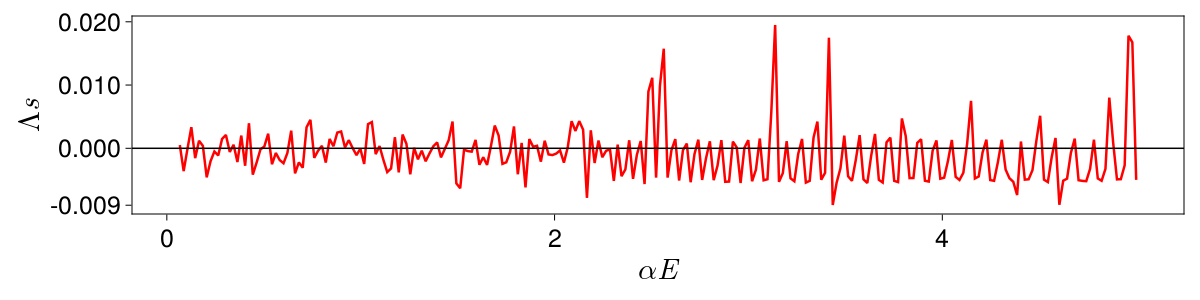

In [37]:
lb_size = 30; tck_size = 25;

f = Figure(resolution = (1200, 300))
axis = Axis(f[1, 1], xlabel = L"αE", ylabel = L"\Lambda s",
            xlabelsize = lb_size, ylabelsize = lb_size,
            xticklabelsize = tck_size, yticklabelsize = tck_size,
            xgridvisible = false, ygridvisible = false, yticks = [-0.009, 0.0, 0.01, 0.02])

lines!(axis, αE_range, Λs[:, 1], linewidth = 2.5, color = :red)
hlines!(axis, 0.0, color = :black, linestyile = :dash)

yticks!
f